In [1]:
### Defining Environment variables pointing to user folders
from os import environ, path, makedirs
from json import load

environ.setdefault('HOME_DIR', "/workarea/local/shared/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE'  ,environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault('FEATHER_FOLDER' ,environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault("TRAIN_DATA"     , environ['FEATHER_FOLDER']+"/acceptance-train")
environ.setdefault("VALIDATION_DATA", environ['FEATHER_FOLDER']+"/acceptance-validation")

environ.setdefault("MODEL_VARIANT","")
default_output_model = "/models/acceptance/saved_model.pb"
if environ['MODEL_VARIANT'] != '':
    model_path,model_name = path.split(default_output_model)
    default_output_model = path.join(model_path,environ['MODEL_VARIANT'], model_name)
environ.setdefault('OUTPUT_MODEL',environ['MODEL_STORAGE']+default_output_model)

with open("Models_definitions.json") as mdl_file: # definition of variant models
    models_def = load(mdl_file)
    environ.setdefault('MODEL_DEFINITION',models_def['acceptance'].get(environ['MODEL_VARIANT'],"AcceptanceNN(layers=10,X_shape=X.shape)"))

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

In [2]:
%run construct_models.py # script containing models definitions

# Training of the *Acceptance model*
##### Tested on environment `TensorFlow on GPU` from [landerlini/lhcbaf:v0p8](https://hub.docker.com/r/landerlini/lhcbaf)

In this notebook we setup the training for the acceptance model, based on a Deep Neural Network.

This notebook is part of a pipeline and requires the data preprocessed with the notebook [Preprocessing.ipynb](./Preprocessing.ipynb).

## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [5]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "acceptance-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "acceptance-validation")).as_tf_dataset()

We load a small batch of data to identify the number of conditional and target features and automate the definition of the neural network architecture.

In [6]:
X, y = next(iter(train_dataset.batch(1_000_000)))
X.shape

TensorShape([1000000, 12])

## Model definition

The function we are modelling is not a trivial one, requiring a sufficiently deep neural network.
In order to limit the effect of the vanishing gradient and make the trainig procedure faster, we are using the concept of Residual Layer, introducing skipping connections between the input and the output of each layer.

With residual layers, the neural network is trained to learn the deviation from identity which is a much less demanding task than learning the whole transformation.

The output layer of the neural network has a sigmoid activation function to be mapped into the interval 0-1 and being interpreted as the **probability for the particle of being in acceptance**.



In [14]:
model = eval(environ["MODEL_DEFINITION"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          1664        input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          16512       dense_7[0][0]                    
__________________________________________________________________________________________________
add_5 (Add)                     (None, 128)          0           dense_7[0][0]                    
                                                                 dense_8[0][0]              

The rest of the training procedure is rather standard:
 * loss function: [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
 * optimizer: [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop) or [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [15]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

To speed up convergence, we split the training procedure in two steps. 
First, we proceed at high learning rate and then we operate some fine tuning of the network drastrically reducing it.
Similar results might be obtained in a more elegant way using a keras [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/).

Instead of setting a fixed number of epochs, we switch from one learning rate to the next one upon lack of improvement for at least 5 epochs.

In [16]:
import subprocess

def plot_weight_distributions1(model,title=""):
    dense_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(dense_layers)))
    ax = plt.axes()
 
    # Setting the background color of the plot
    # using set_facecolor() method
    ax.set_facecolor("darkgrey")
    #mins,maxs= [],[]
    
    for i, layer in enumerate(dense_layers):
        weights = layer.get_weights()[0].flatten()  # Flatten the weights
        #mins.append(weights.min())
        #maxs.append(weights.max())
        label = f"{layer.__class__.__name__} {i+1}, #w: {weights.shape[0]}"
        plt.hist(weights, density=True, bins="auto", histtype='step', color=colors[i], label=label)

    if title != "":
        plt.title(title)
    plt.xlim(-2,2)
    #plt.xlim(min(mins),max(maxs))
    plt.xlabel('Weight Value')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    
def plot_weight_distributions(model,title=""):
    dense_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(np.linspace(0, 1, len(dense_layers)))
    fig,axes = plt.subplots(1,2,figsize=(16,5))
 
    # Setting the background color of the plot
    # using set_facecolor() method
    for ax in axes:
        ax.set_facecolor("darkgrey")
    
    for i, layer in enumerate(dense_layers):
        weights = layer.get_weights()[0].flatten()  # Flatten the weights
        bias    = layer.get_weights()[1]
        wlabel = f"{layer.__class__.__name__} {i+1}, #w: {weights.shape[0]}"
        blabel = f"{layer.__class__.__name__} {i+1}, #b: {bias.shape[0]}"
        axes[0].hist(weights, density=True, bins="auto", histtype='step', color=colors[i], label=wlabel)
        axes[1].hist(bias, density=True, bins="auto", histtype='step', color=colors[i], label=blabel, facecolor='black')

    if title != "":
        axes[0].set_title(title+" - weights")
        axes[1].set_title(title+" - bias")
    for ax in axes:
        ax.set_xlim(-2,2)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Counts')
        ax.legend()
    plt.show()
    
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_check=0):
        """ Save params in constructor
        """
        self.epoch_check = epoch_check
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch==0:
            title = f"Before epoch {epoch+1}"
            plot_weight_distributions(self.model,title)
    def on_epoch_end(self, epoch, logs=None):
        batcmd="nvidia-smi --query-gpu=utilization.gpu --format=csv"
        result = subprocess.check_output(batcmd, shell=True,text=True)
        print("GPU: ",result.split('\n')[1])
        #used,tot = result.split('\n')[1].split(",")
        #gpu_used = int(used.split(' ')[0])/int(tot.split(' ')[1])
        #print(f"GPU used: {gpu_used*100:.2f}")
        if (epoch+1)%self.epoch_check==0:
            title = f"End epoch {epoch+1}"
            plot_weight_distributions(self.model,title)


In [17]:

from datetime import datetime
# Create a TensorBoard callback
logs = "touched/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')


Epoch 1/50


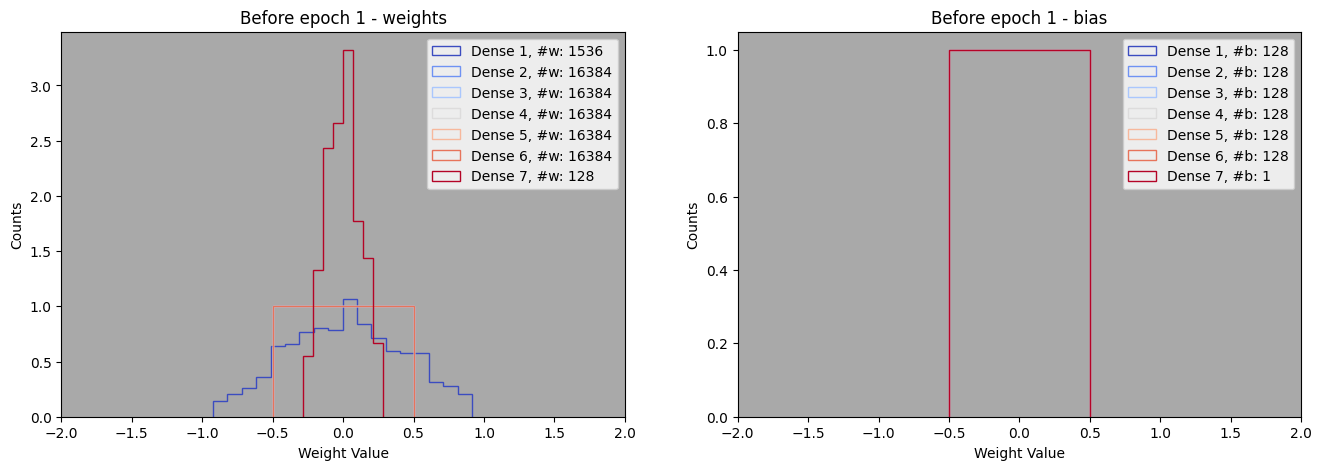

26/26 [==============================] - 8s 265ms/step - loss: 1.1482 - root_mean_squared_error: 0.4855 - val_loss: 0.7915 - val_root_mean_squared_error: 0.4396
GPU:  32 %
Epoch 2/50
26/26 [==============================] - 7s 261ms/step - loss: 0.6905 - root_mean_squared_error: 0.4078 - val_loss: 0.6661 - val_root_mean_squared_error: 0.4087
GPU:  15 %
Epoch 3/50
26/26 [==============================] - 7s 264ms/step - loss: 0.5467 - root_mean_squared_error: 0.3583 - val_loss: 0.5613 - val_root_mean_squared_error: 0.3738
GPU:  10 %
Epoch 4/50
26/26 [==============================] - 7s 256ms/step - loss: 0.4531 - root_mean_squared_error: 0.3245 - val_loss: 0.3933 - val_root_mean_squared_error: 0.2986
GPU:  17 %
Epoch 5/50
26/26 [==============================] - 10s 354ms/step - loss: 0.4102 - root_mean_squared_error: 0.3117 - val_loss: 0.3784 - val_root_mean_squared_error: 0.3005
GPU:  0 %
Epoch 6/50
26/26 [==============================] - 7s 261ms/step - loss: 0.3613 - root_mean_squ

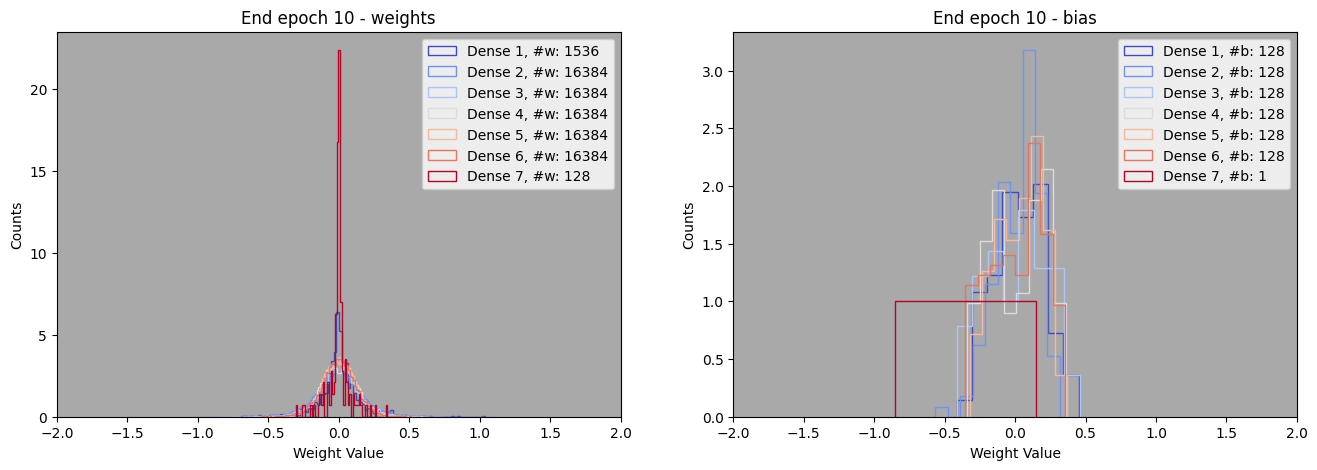

Epoch 11/50
26/26 [==============================] - 8s 265ms/step - loss: 0.2840 - root_mean_squared_error: 0.2667 - val_loss: 0.2694 - val_root_mean_squared_error: 0.2591
GPU:  10 %
Epoch 12/50
26/26 [==============================] - 8s 264ms/step - loss: 0.2740 - root_mean_squared_error: 0.2626 - val_loss: 0.2698 - val_root_mean_squared_error: 0.2602
GPU:  19 %
Epoch 13/50
26/26 [==============================] - 7s 262ms/step - loss: 0.2665 - root_mean_squared_error: 0.2591 - val_loss: 0.2535 - val_root_mean_squared_error: 0.2519
GPU:  9 %
Epoch 14/50
26/26 [==============================] - 10s 354ms/step - loss: 0.2615 - root_mean_squared_error: 0.2567 - val_loss: 0.2628 - val_root_mean_squared_error: 0.2591
GPU:  0 %
Epoch 15/50
26/26 [==============================] - 7s 262ms/step - loss: 0.2558 - root_mean_squared_error: 0.2543 - val_loss: 0.2606 - val_root_mean_squared_error: 0.2570
GPU:  35 %
Epoch 16/50
26/26 [==============================] - 8s 269ms/step - loss: 0.2534

In [18]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping,CustomCallback(epoch_check=10)])

In [13]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [29]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir="/local/shared/scapelli/lb-trksim-train/notebooks/touched/20230522-120409"

In [ ]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping,CustomCallback(epoch_check=10)])
plot_weight_distributions(model,title="End training")

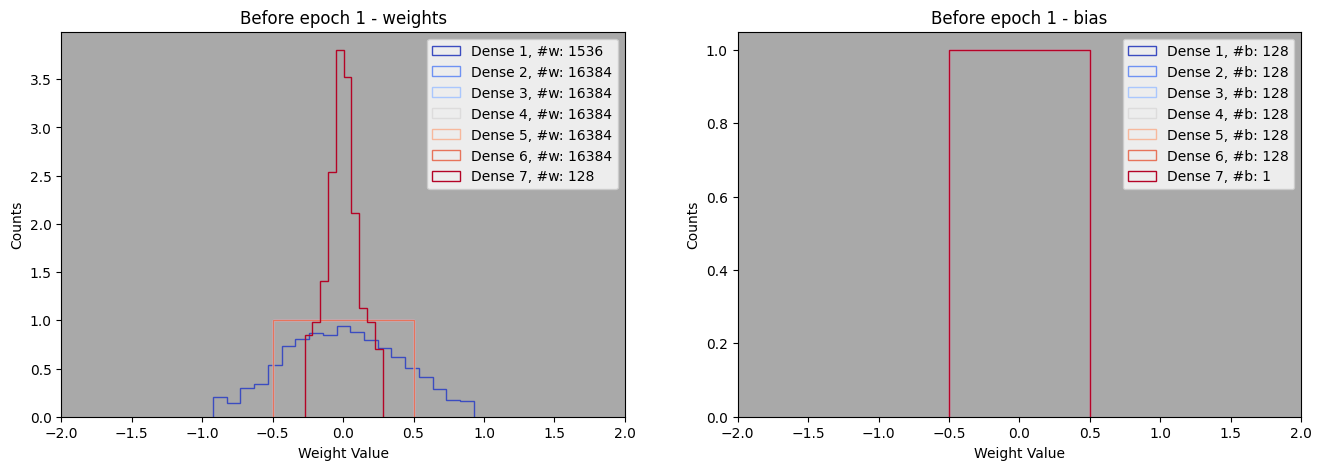

Epoch 1/50
26/26 [==============================] - 12s 408ms/step - loss: 1.1861 - root_mean_squared_error: 0.4623 - val_loss: 0.7117 - val_root_mean_squared_error: 0.4074
Epoch 2/50
26/26 [==============================] - 13s 474ms/step - loss: 0.6542 - root_mean_squared_error: 0.3886 - val_loss: 0.5332 - val_root_mean_squared_error: 0.3428
Epoch 3/50
26/26 [==============================] - 11s 390ms/step - loss: 0.5031 - root_mean_squared_error: 0.3389 - val_loss: 0.4294 - val_root_mean_squared_error: 0.3156
Epoch 4/50
26/26 [==============================] - 10s 387ms/step - loss: 0.4211 - root_mean_squared_error: 0.3134 - val_loss: 0.3512 - val_root_mean_squared_error: 0.2799
Epoch 5/50
26/26 [==============================] - 11s 391ms/step - loss: 0.3685 - root_mean_squared_error: 0.2960 - val_loss: 0.3199 - val_root_mean_squared_error: 0.2705
Epoch 6/50
26/26 [==============================] - 13s 478ms/step - loss: 0.3382 - root_mean_squared_error: 0.2852 - val_loss: 0.3189 

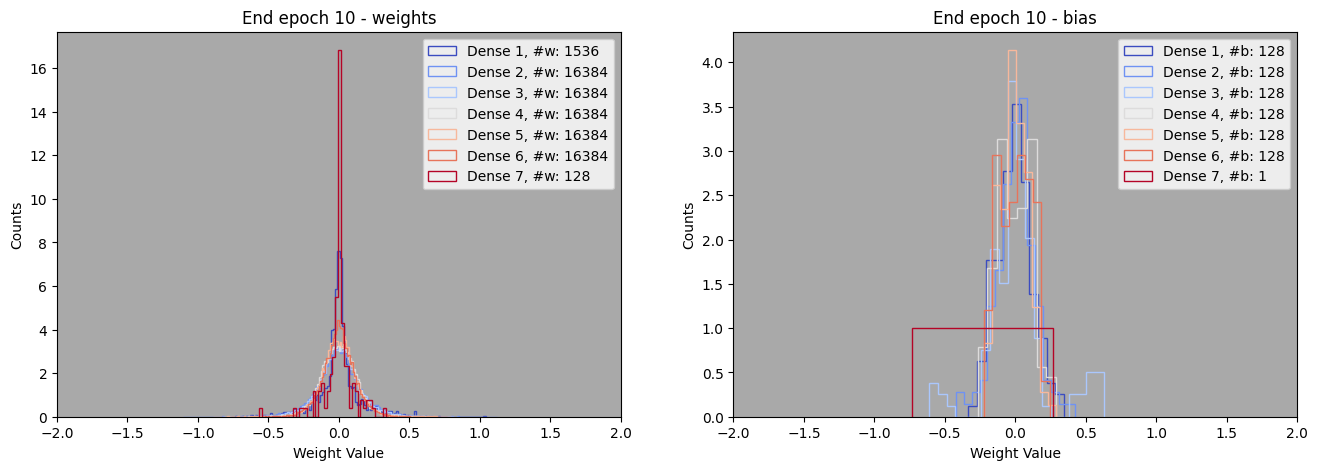

26/26 [==============================] - 11s 404ms/step - loss: 0.2714 - root_mean_squared_error: 0.2589 - val_loss: 0.2617 - val_root_mean_squared_error: 0.2529
Epoch 11/50
26/26 [==============================] - 10s 388ms/step - loss: 0.2613 - root_mean_squared_error: 0.2547 - val_loss: 0.2732 - val_root_mean_squared_error: 0.2630
Epoch 12/50
26/26 [==============================] - 11s 393ms/step - loss: 0.2590 - root_mean_squared_error: 0.2546 - val_loss: 0.2423 - val_root_mean_squared_error: 0.2443
Epoch 13/50
26/26 [==============================] - 11s 391ms/step - loss: 0.2532 - root_mean_squared_error: 0.2525 - val_loss: 0.2718 - val_root_mean_squared_error: 0.2634
Epoch 14/50
26/26 [==============================] - 13s 472ms/step - loss: 0.2492 - root_mean_squared_error: 0.2505 - val_loss: 0.2520 - val_root_mean_squared_error: 0.2543
Epoch 15/50
26/26 [==============================] - 13s 473ms/step - loss: 0.2454 - root_mean_squared_error: 0.2486 - val_loss: 0.2786 - val_

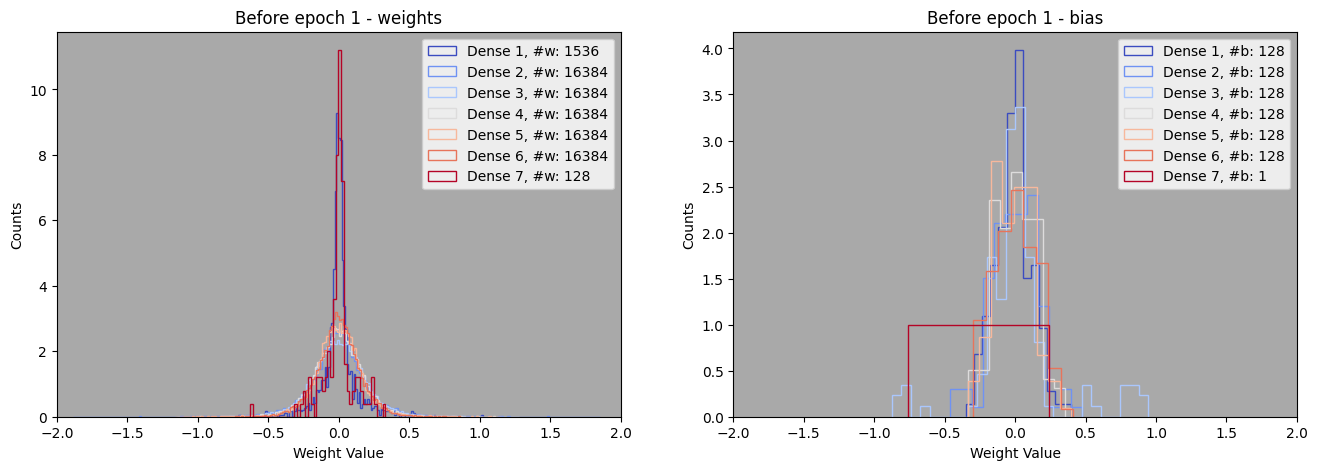

Epoch 1/50
26/26 [==============================] - 11s 391ms/step - loss: 0.1889 - root_mean_squared_error: 0.2211 - val_loss: 0.1769 - val_root_mean_squared_error: 0.2136
Epoch 2/50
26/26 [==============================] - 10s 387ms/step - loss: 0.1736 - root_mean_squared_error: 0.2114 - val_loss: 0.1688 - val_root_mean_squared_error: 0.2084
Epoch 3/50
26/26 [==============================] - 11s 390ms/step - loss: 0.1671 - root_mean_squared_error: 0.2073 - val_loss: 0.1631 - val_root_mean_squared_error: 0.2046
Epoch 4/50
26/26 [==============================] - 10s 386ms/step - loss: 0.1621 - root_mean_squared_error: 0.2041 - val_loss: 0.1586 - val_root_mean_squared_error: 0.2013
Epoch 5/50
26/26 [==============================] - 10s 386ms/step - loss: 0.1583 - root_mean_squared_error: 0.2016 - val_loss: 0.1550 - val_root_mean_squared_error: 0.1990
Epoch 6/50
26/26 [==============================] - 10s 381ms/step - loss: 0.1552 - root_mean_squared_error: 0.1996 - val_loss: 0.1524 

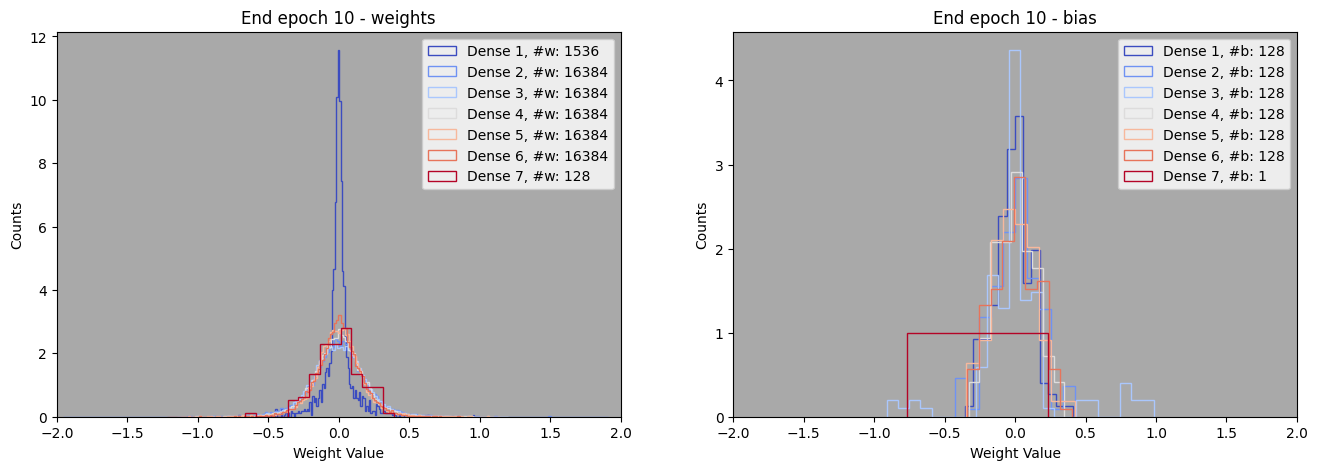

26/26 [==============================] - 10s 386ms/step - loss: 0.1472 - root_mean_squared_error: 0.1946 - val_loss: 0.1497 - val_root_mean_squared_error: 0.1970
Epoch 11/50
26/26 [==============================] - 10s 387ms/step - loss: 0.1465 - root_mean_squared_error: 0.1943 - val_loss: 0.1437 - val_root_mean_squared_error: 0.1918
Epoch 12/50
26/26 [==============================] - 11s 394ms/step - loss: 0.1450 - root_mean_squared_error: 0.1934 - val_loss: 0.1467 - val_root_mean_squared_error: 0.1952
Epoch 13/50
26/26 [==============================] - 13s 473ms/step - loss: 0.1444 - root_mean_squared_error: 0.1932 - val_loss: 0.1432 - val_root_mean_squared_error: 0.1920
Epoch 14/50
26/26 [==============================] - 11s 396ms/step - loss: 0.1435 - root_mean_squared_error: 0.1927 - val_loss: 0.1407 - val_root_mean_squared_error: 0.1900
Epoch 15/50
26/26 [==============================] - 10s 384ms/step - loss: 0.1425 - root_mean_squared_error: 0.1920 - val_loss: 0.1405 - val_

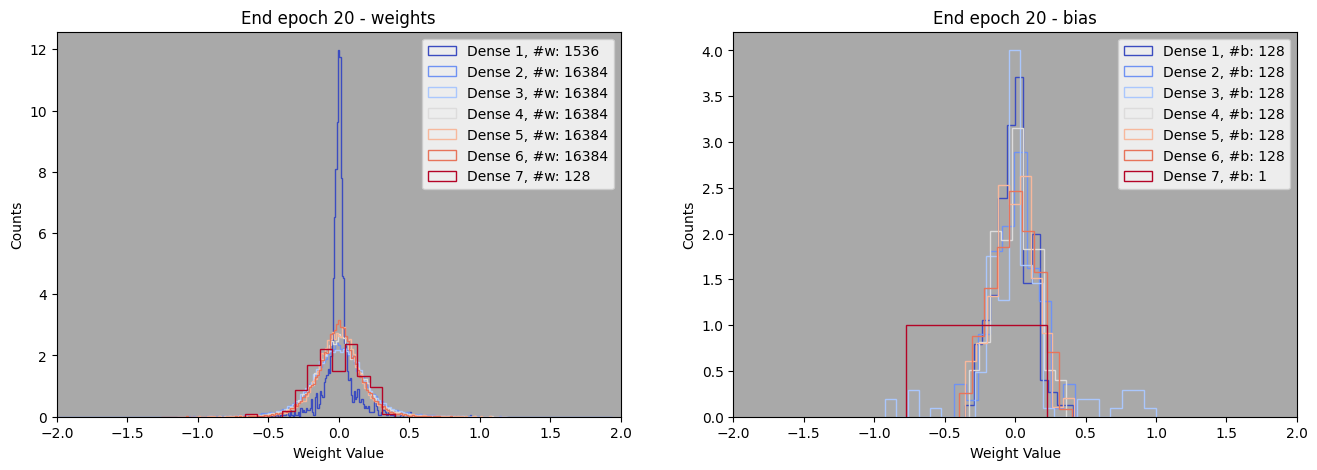

26/26 [==============================] - 13s 482ms/step - loss: 0.1392 - root_mean_squared_error: 0.1902 - val_loss: 0.1382 - val_root_mean_squared_error: 0.1892
Epoch 21/50
26/26 [==============================] - 10s 387ms/step - loss: 0.1391 - root_mean_squared_error: 0.1904 - val_loss: 0.1371 - val_root_mean_squared_error: 0.1884
Epoch 22/50
26/26 [==============================] - 10s 387ms/step - loss: 0.1382 - root_mean_squared_error: 0.1897 - val_loss: 0.1361 - val_root_mean_squared_error: 0.1877
Epoch 23/50
26/26 [==============================] - 10s 389ms/step - loss: 0.1378 - root_mean_squared_error: 0.1896 - val_loss: 0.1374 - val_root_mean_squared_error: 0.1891
Epoch 24/50
26/26 [==============================] - 10s 389ms/step - loss: 0.1377 - root_mean_squared_error: 0.1896 - val_loss: 0.1363 - val_root_mean_squared_error: 0.1882
Epoch 25/50
26/26 [==============================] - 13s 472ms/step - loss: 0.1370 - root_mean_squared_error: 0.1892 - val_loss: 0.1402 - val_

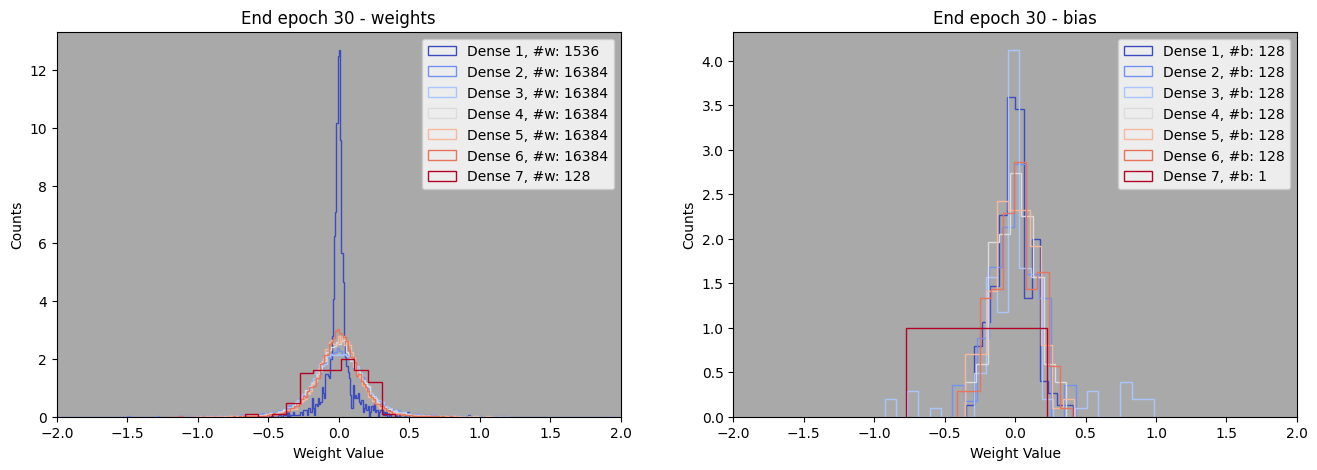

26/26 [==============================] - 13s 489ms/step - loss: 0.1353 - root_mean_squared_error: 0.1884 - val_loss: 0.1382 - val_root_mean_squared_error: 0.1912
Epoch 31/50
26/26 [==============================] - 10s 386ms/step - loss: 0.1349 - root_mean_squared_error: 0.1882 - val_loss: 0.1336 - val_root_mean_squared_error: 0.1872
Epoch 32/50
26/26 [==============================] - 13s 474ms/step - loss: 0.1348 - root_mean_squared_error: 0.1883 - val_loss: 0.1329 - val_root_mean_squared_error: 0.1863
Epoch 33/50
26/26 [==============================] - 13s 474ms/step - loss: 0.1344 - root_mean_squared_error: 0.1880 - val_loss: 0.1339 - val_root_mean_squared_error: 0.1875
Epoch 34/50
26/26 [==============================] - 13s 473ms/step - loss: 0.1337 - root_mean_squared_error: 0.1874 - val_loss: 0.1345 - val_root_mean_squared_error: 0.1882
Epoch 35/50
26/26 [==============================] - 10s 384ms/step - loss: 0.1340 - root_mean_squared_error: 0.1878 - val_loss: 0.1316 - val_

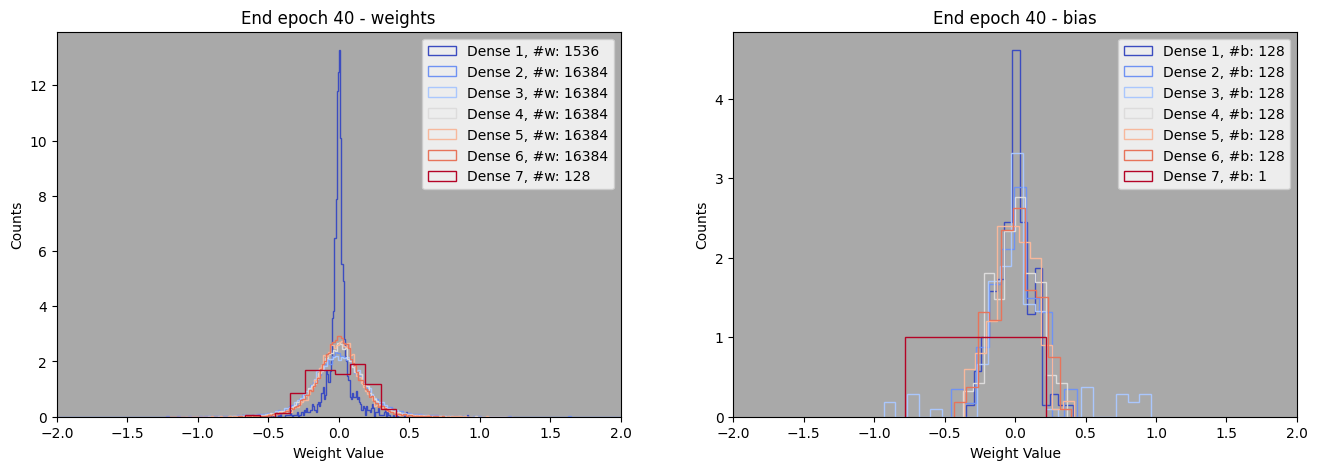

26/26 [==============================] - 13s 487ms/step - loss: 0.1323 - root_mean_squared_error: 0.1869 - val_loss: 0.1322 - val_root_mean_squared_error: 0.1869
Epoch 41/50
26/26 [==============================] - 11s 391ms/step - loss: 0.1319 - root_mean_squared_error: 0.1867 - val_loss: 0.1331 - val_root_mean_squared_error: 0.1875
Epoch 42/50
26/26 [==============================] - 11s 390ms/step - loss: 0.1320 - root_mean_squared_error: 0.1869 - val_loss: 0.1359 - val_root_mean_squared_error: 0.1904
Epoch 43/50
26/26 [==============================] - 10s 372ms/step - loss: 0.1316 - root_mean_squared_error: 0.1866 - val_loss: 0.1326 - val_root_mean_squared_error: 0.1876
Epoch 44/50
26/26 [==============================] - 12s 470ms/step - loss: 0.1311 - root_mean_squared_error: 0.1862 - val_loss: 0.1304 - val_root_mean_squared_error: 0.1852


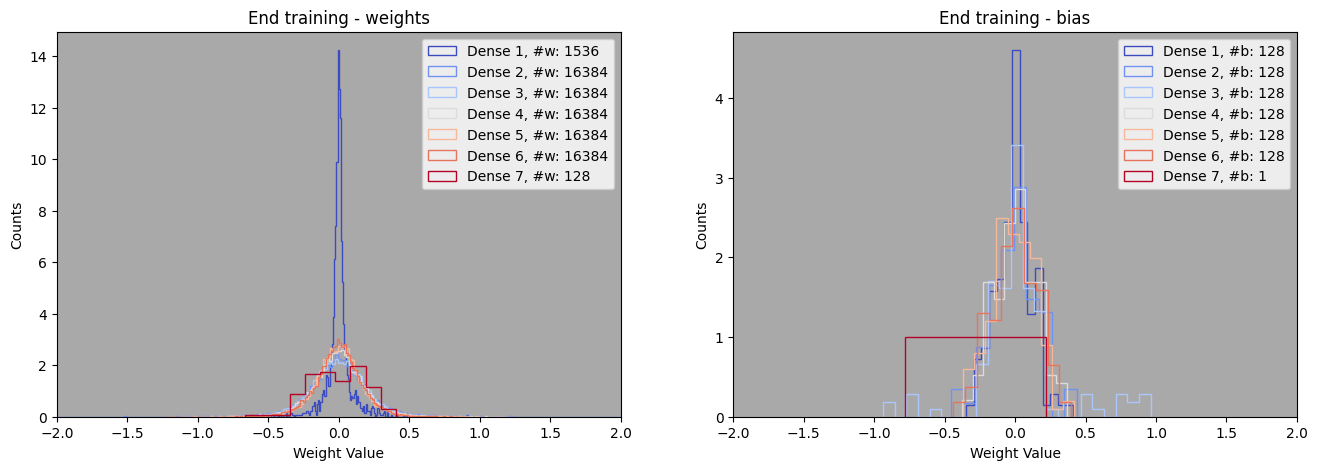

In [11]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping,CustomCallback(epoch_check=10)])

model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping,CustomCallback(epoch_check=10)])
plot_weight_distributions(model,title="End training")

The two regimes are well visibile in the plot below, combining the two training phases in a single epoch count.

Epoch 1/50


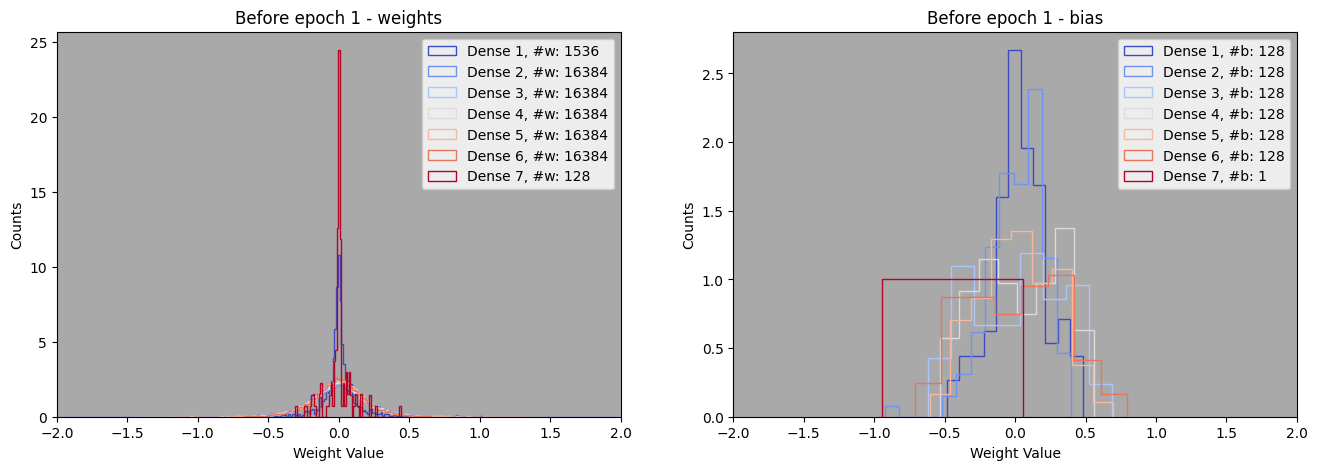

26/26 [==============================] - 8s 269ms/step - loss: 0.2377 - root_mean_squared_error: 0.2451 - val_loss: 0.2380 - val_root_mean_squared_error: 0.2449
GPU:  33 %
Epoch 2/50
26/26 [==============================] - 7s 260ms/step - loss: 0.2379 - root_mean_squared_error: 0.2452 - val_loss: 0.2258 - val_root_mean_squared_error: 0.2385
GPU:  24 %
Epoch 3/50
26/26 [==============================] - 8s 268ms/step - loss: 0.2330 - root_mean_squared_error: 0.2428 - val_loss: 0.2273 - val_root_mean_squared_error: 0.2389
GPU:  8 %
Epoch 4/50
26/26 [==============================] - 7s 261ms/step - loss: 0.2316 - root_mean_squared_error: 0.2421 - val_loss: 0.2285 - val_root_mean_squared_error: 0.2398
GPU:  33 %
Epoch 5/50
26/26 [==============================] - 7s 265ms/step - loss: 0.2298 - root_mean_squared_error: 0.2411 - val_loss: 0.2367 - val_root_mean_squared_error: 0.2485
GPU:  32 %


In [19]:
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping,CustomCallback(epoch_check=10)])

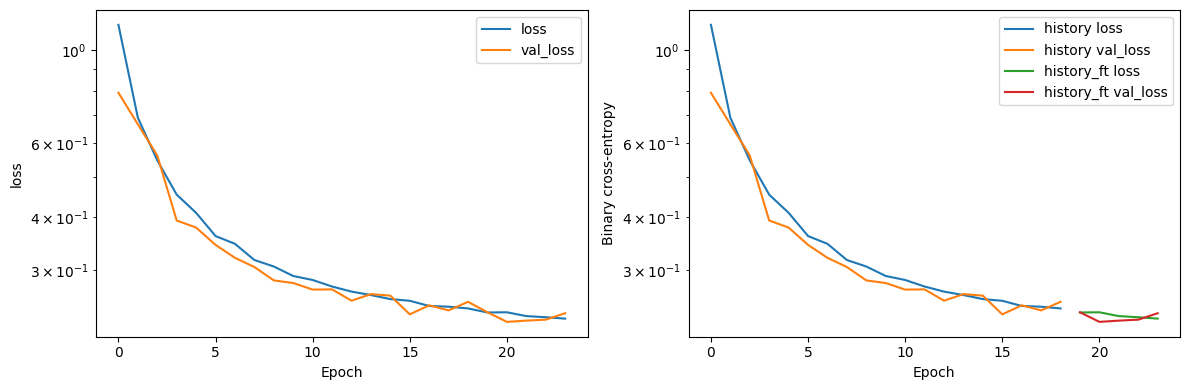

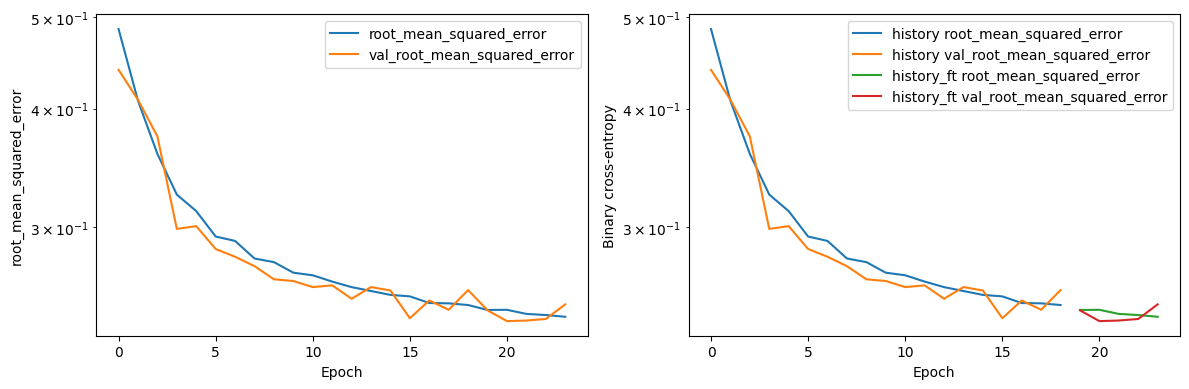

In [20]:
def plot_history(history,history_ft):
    """plot training history"""

    metrics = list(history.history.keys())
    for m in range(int(len(metrics)/2)):
        fig,axes = plt.subplots(1,2,figsize=(12,4))

        m_train,m_val = metrics[m], metrics[m + int(len(metrics)/2)]
        axes[0].plot(history.history[m_train] + history_ft.history[m_train], label=m_train)
        axes[0].plot(history.history[m_val] + history_ft.history[m_val], label=m_val)
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel(m_train)
        axes[0].set_yscale('log')
        axes[0].legend()
        
        e_h   = np.arange(len(history.history['loss']))
        e_hft = np.arange(len(history_ft.history['loss']))
        axes[1].plot(e_h,history.history[m_train]       , label=f"history {m_train}")
        axes[1].plot(e_h,history.history[m_val]   , label=f"history {m_val}")
        axes[1].plot(e_hft+len(e_h),history_ft.history[m_train], label=f"history_ft {m_train}")
        axes[1].plot(e_hft+len(e_h),history_ft.history[m_val], label=f"history_ft {m_val}")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Binary cross-entropy")
        axes[1].set_yscale('log')
        axes[1].legend()
        plt.tight_layout()
        plt.show()

plot_history(history,history_ft)

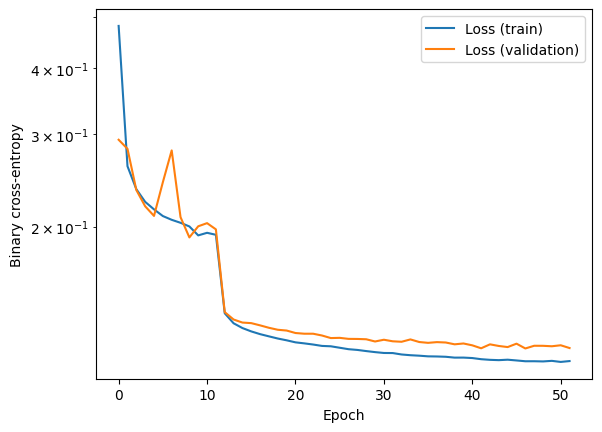

In [101]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.legend()
plt.show()

## A first, rough validation

While a proper validation of the model is demanded to a dedicated notebook, here we check that the training was not completely failed and provides reasonable numbers.

In particular, we compare the distributions of the training lables and of the predictions.

Clearly, the training labels are either 1 or 0 because a particle is either in acceptance or not. Instead, the output of the neural network is a probability and hence it will be distributed between 0 and 1. 

The comparison is used to ensure that both the training labels and the network output are not unreasonable, for example collapsed into a single value or with training labels belonging to a single category.

1/1 [==============================] - 0s 474ms/step


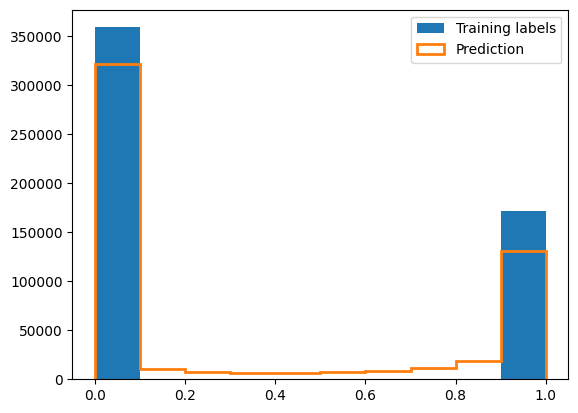

In [14]:
Xv, yv = next(iter(validation_dataset.batch(1_000_000).as_numpy_iterator()))
yv_hat = model.predict(Xv, batch_size=len(Xv))
bins = np.linspace(0, 1, 11)
plt.hist(yv, bins=bins, label="Training labels")
plt.hist(yv_hat, bins=bins, histtype='step', linewidth=2, label="Prediction")
plt.legend()
plt.show()

Then we can compare the distribution of a preprocessed variable before and after the application of the acceptance requirement.

Here, for example, we consider the preprocessed log-value of the momentum.

Since the variable is preprocessed, without applying any cut (**Generated**) we have a perfectly normalized Gaussian.

Applying the criterion `acceptance == 1` we get another distribution that we expect to model with decent approximation by applying the response of the trained neural networks as weights to the **Generated** dataset.

The comparison of the two histograms (obtained by applying a cut on the true acceptance or applying a weight on the acceptance probability) provides a first validation on the quality of the parametrization.

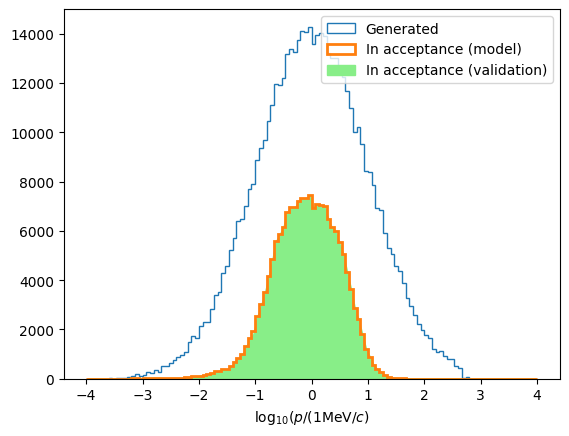

In [15]:
log_p = Xv[:,3]
bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p, bins=bins, weights=yv.flatten())
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=yv_hat.flatten())

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="In acceptance (model)", histtype='step', linewidth=2)
#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="In acceptance (validation)",
    color='#88ee88'
)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

## Export the model
Finally, we export the model to the same folder where the pretraining step was stored.

In [22]:
from models_utils import GetModelProperties,MakeMD
from json import dump

base_dir = path.dirname(environ['OUTPUT_MODEL'])
makedirs(base_dir,exist_ok=True)
model.save(base_dir)

# save model and training information
jsonfile = "model_info.json"
info_path = path.join(base_dir, jsonfile)
props = GetModelProperties(model,history=history_ft)

with open(path.join(base_dir, jsonfile),'w') as json_file:
    dump(props,json_file)

# write model description in MD file
MakeMD(props,mdfile=path.join(base_dir, "model_info.md"))

INFO:tensorflow:Assets written to: /workarea/local/shared/scapelli/trained_models/j100/models/acceptance/v1/assets


/usr/local/miniconda3/envs/tf_on_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Conclusion

In this notebook we have:
 * loaded the training and validation data
 * defined a neural network model for the acceptance
 * trained the model on simulated data
 * performed a couple of sanity checks to ensure the training procedure did not fail
 * exported the model to disk
 
In the next notebook we will perform a more detaile validation, by splitting the sample in kinematic bins and comparing for each bin the distribution of particles in acceptance.

In [27]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,rename,path,makedirs
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']                     # according to train data
    if environ['MODEL_VARIANT'] != '':
        nb_save  = nb_save+'/'+environ['MODEL_VARIANT']                    # according to model variant
    if not path.isdir(nb_save): makedirs(nb_save,exist_ok=True)         # create if not exists
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Acceptance.ipynb"                                       # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Acceptance.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports/j100/v1
